# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1) Describe and clean the datasets

## 1.A) Describe the Portfolio dataset

In [2]:
#Inspect the entire table
print(portfolio.shape)
portfolio[['id', 'offer_type', 'difficulty', 'reward', 'duration', 'channels']].sort_values('offer_type').head(10)

(10, 6)


,id,offer_type,difficulty,reward,duration,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,"[email, mobile, social]"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,"[web, email, mobile, social]"
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,"[web, email, mobile]"
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,"[web, email, mobile, social]"
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,5,10,"[web, email]"
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,"[web, email, mobile, social]"
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,"[web, email, mobile, social]"
9,2906b810c7d4411798c6938adc9daaa5,discount,10,2,7,"[web, email, mobile]"
2,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,"[web, email, mobile]"
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,"[email, mobile, social]"


In [3]:
#Count the number of nulls in each column
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

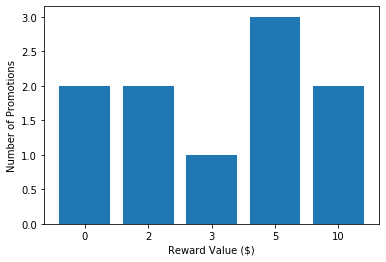

In [4]:
#Inspect the 'reward' column
df = portfolio['reward'].value_counts().sort_index()
vals = df.index.values.astype(str)
plt.bar(vals, df.values)
plt.xlabel("Reward Value ($)")
plt.ylabel("Number of Promotions")
plt.show()

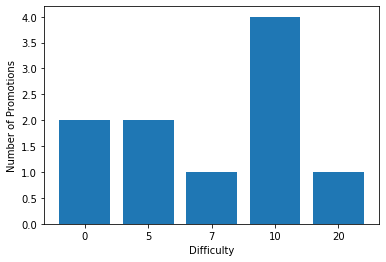

In [5]:
#Inspect the 'difficulty' column
df = portfolio['difficulty'].value_counts().sort_index()
vals = df.index.values.astype(str)
plt.bar(vals, df.values)
plt.xlabel("Difficulty")
plt.ylabel("Number of Promotions")
plt.show()

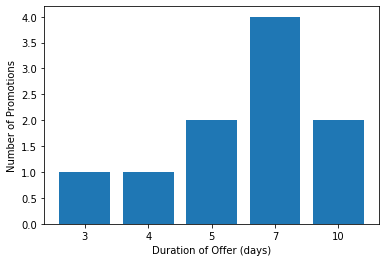

In [6]:
#Inspect the 'duration' column
df = portfolio['duration'].value_counts().sort_index()
vals = df.index.values.astype(str)
plt.bar(vals, df.values)
plt.xlabel("Duration of Offer (days)")
plt.ylabel("Number of Promotions")
plt.show()

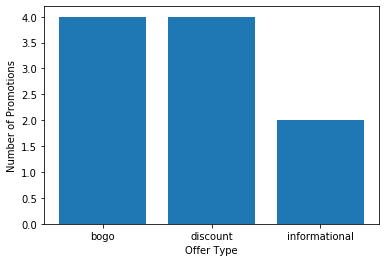

In [7]:
#Inspect the 'offer type' column
df = portfolio['offer_type'].value_counts().sort_index()
vals = df.index.values.astype(str)
plt.bar(vals, df.values)
plt.xlabel("Offer Type")
plt.ylabel("Number of Promotions")
plt.show()

## 1.B) Clean the Portfolio dataset

In [8]:
#Get all unique values from 'channels' column
channels = []
for i in portfolio.index:
    channels = channels + portfolio.loc[i]['channels']
channels = np.array(channels)
cols = list(np.unique(channels))
cols

['email', 'mobile', 'social', 'web']

In [9]:
#Create new columns for channel and indicate association (1=True, 0=False)
port_clean=portfolio.copy()
for c in cols:
    port_clean[c]=0
    
for c in cols:
    port_clean[c] = portfolio.apply(lambda x: 1 if c in x['channels'] else 0, axis=1)

#Drop 'channels' column, rename 'id' column, set index
port_clean.drop('channels', axis=1, inplace=True)
port_clean.rename({'id': 'offer_id'}, axis=1, inplace=True)
port_clean.set_index('offer_id', inplace=True)
port_clean.head()

,reward,difficulty,duration,offer_type,email,mobile,social,web
offer_id,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,1,1,1,0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,1,1,1,1
3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,0,1
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,1,0,0,1


In [10]:
#Create dummy columns for 'offer_type'
for t in np.unique(port_clean['offer_type'].values):
    port_clean[t]=(port_clean['offer_type']==t).astype(int)
    
port_clean.drop('offer_type', axis=1, inplace=True)
port_clean.head()

,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
offer_id,,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,1,1,0,1,0,0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0
3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,0,1,0,0,1
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,0,1,1,0,0
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,0,0,1,0,1,0


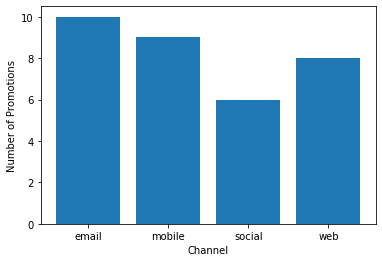

In [11]:
#Inspect the 'channel' column
channels = ['email', 'mobile', 'social', 'web']
totals = []
for f in channels:
    totals.append(port_clean[f].sum())
totals

plt.bar(channels, totals)
plt.xlabel("Channel")
plt.ylabel("Number of Promotions")
plt.show()

## 1.C) Describe the Profile dataset

In [12]:
#Inspect the entire table
print(profile.shape)
profile[['id', 'gender', 'age', 'became_member_on', 'income']].head()

(17000, 5)


,id,gender,age,became_member_on,income
0,68be06ca386d4c31939f3a4f0e3dd783,None,118,20170212,NaN
1,0610b486422d4921ae7d2bf64640c50b,F,55,20170715,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,None,118,20180712,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0
4,a03223e636434f42ac4c3df47e8bac43,None,118,20170804,NaN


In [13]:
#Display data type of each column
profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

In [14]:
#Count Null values in each column
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

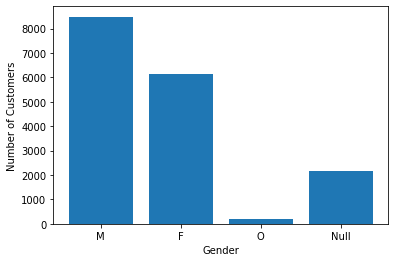

In [15]:
#Inspect the 'gender' column
df = profile.copy()
df['gender'].fillna('Null', inplace=True)
df = df.groupby('gender').count()
df = df.loc[['M', 'F', 'O', 'Null']]
plt.bar(df.index, df.id)
plt.xlabel("Gender")
plt.ylabel("Number of Customers")
plt.show()

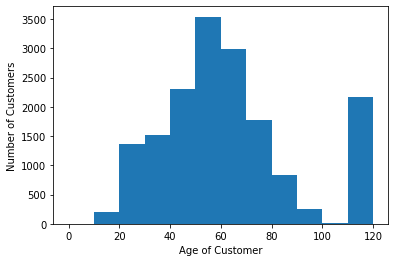

In [16]:
#Inspect the 'age' column
plt.hist(profile['age'].values, bins=range(0,130,10))
plt.xlabel("Age of Customer")
plt.ylabel("Number of Customers")
plt.show()

In [17]:
profile[profile.age<118].age.describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

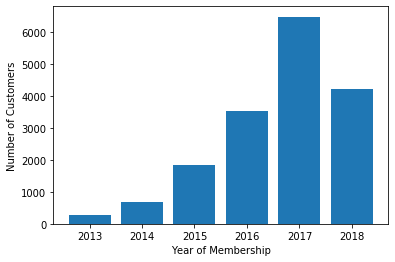

In [18]:
#Inspect the 'became_member_on' column
year = profile['became_member_on'].apply(lambda x: str(x)[0:4])
df = year.value_counts().sort_index()
plt.bar(df.index, df.values)
plt.xlabel("Year of Membership")
plt.ylabel("Number of Customers")
plt.show()

In [19]:
#First and last membership dates
print(profile.became_member_on.astype(str).min())
print(profile.became_member_on.astype(str).max())

20130729
20180726


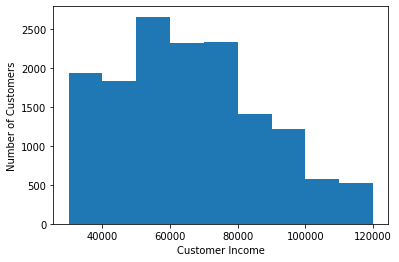

In [20]:
#Inspect the 'income' column
df = profile[profile['income'].notnull()]['income']
plt.hist(df.values, bins=range(30000,130000,10000))
plt.xlabel("Customer Income")
plt.ylabel("Number of Customers")
plt.show()

In [21]:
profile.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

## 1.D) Clean the Profile dataset

First, remove all rows with invalid customer information.

In [22]:
#Create dataframe where 'gender' is Null
df = profile[profile['gender'].isnull()]

#Print total rows and number of Null values in each column
print(df.shape[0], " total rows")
df.isnull().sum()

2175  total rows


gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [23]:
#Confirm that all rows contain age=118
df['age'].value_counts()

118    2175
Name: age, dtype: int64

In [24]:
#Remove all rows where 'gender' is null because these rows do not contain gender, age, or income information and 
#therefore are not useful for developing a classification model
prof_clean = profile[profile['gender'].notnull()].copy()
prof_clean.rename({'id':'person_id'}, axis=1, inplace=True)
prof_clean.set_index('person_id', inplace=True)
prof_clean.head()

,gender,age,became_member_on,income
person_id,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,20170715,112000.0
78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0
e2127556f4f64592b11af22de27a7932,M,68,20180426,70000.0
389bc3fa690240e798340f5a15918d5c,M,65,20180209,53000.0
2eeac8d8feae4a8cad5a6af0499a211d,M,58,20171111,51000.0


In [25]:
#Create dummy columns for 'gender'
for g in np.unique(prof_clean['gender'].values):
    prof_clean[g]=(prof_clean['gender']==g).astype(int)
    #prof_clean['F'] = prof_clean['F'].astype(int)

prof_clean.drop('gender', axis=1, inplace=True)
prof_clean.head()

,age,became_member_on,income,F,M,O
person_id,,,,,,
0610b486422d4921ae7d2bf64640c50b,55,20170715,112000.0,1,0,0
78afa995795e4d85b5d9ceeca43f5fef,75,20170509,100000.0,1,0,0
e2127556f4f64592b11af22de27a7932,68,20180426,70000.0,0,1,0
389bc3fa690240e798340f5a15918d5c,65,20180209,53000.0,0,1,0
2eeac8d8feae4a8cad5a6af0499a211d,58,20171111,51000.0,0,1,0


In [26]:
#Create dummy columns for 'age' (group by 25-yr range)
prof_clean['0-25']=(prof_clean['age']<=25).astype(int)
prof_clean['26-50']=((prof_clean['age']<=50) & (prof_clean['age']>25)).astype(int)
prof_clean['51-75']=((prof_clean['age']<=75) & (prof_clean['age']>50)).astype(int)
prof_clean['75+']=(prof_clean['age']>75).astype(int)

prof_clean.drop('age', axis=1, inplace=True)
prof_clean.head()

,became_member_on,income,F,M,O,0-25,26-50,51-75,75+
person_id,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,0,0,0,0,1,0
78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1,0,0,0,0,1,0
e2127556f4f64592b11af22de27a7932,20180426,70000.0,0,1,0,0,0,1,0
389bc3fa690240e798340f5a15918d5c,20180209,53000.0,0,1,0,0,0,1,0
2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,0,1,0,0,0,1,0


In [27]:
#Create dummy columns for 'became_member_on' (group by year)
prof_clean['yr']=prof_clean['became_member_on'].apply(lambda x: str(x)[0:4])
for y in np.unique(prof_clean['yr'].values):
    prof_clean[y]=(prof_clean['yr']==y).astype(int)
    
prof_clean.drop(['became_member_on', 'yr'], axis=1, inplace=True)
prof_clean.head()

,income,F,M,O,0-25,26-50,51-75,75+,2013,2014,2015,2016,2017,2018
person_id,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,0,0,1,0,0,0,0,0,1,0
78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,0,0,1,0,0,0,0,0,1,0
e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,0,0,1,0,0,0,0,0,0,1
389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,0,0,1,0,0,0,0,0,0,1
2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,0,0,1,0,0,0,0,0,1,0


In [28]:
#Create dummy columns for 'income' (group by income range)
prof_clean['0-40K']=(prof_clean['income']<=40000).astype(int)
prof_clean['40-80K']=((prof_clean['income']<=80000) & (prof_clean['income']>40000)).astype(int)
prof_clean['80K+']=(prof_clean['income']>80000).astype(int)

prof_clean.drop('income', axis=1, inplace=True)
prof_clean.head()

,F,M,O,0-25,26-50,51-75,75+,2013,2014,2015,2016,2017,2018,0-40K,40-80K,80K+
person_id,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
78afa995795e4d85b5d9ceeca43f5fef,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
e2127556f4f64592b11af22de27a7932,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0
389bc3fa690240e798340f5a15918d5c,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0
2eeac8d8feae4a8cad5a6af0499a211d,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0


## 1.E) Describe the Transcript dataset

In [29]:
#Inspect entire table
print(transcript.shape)
transcript.head()

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


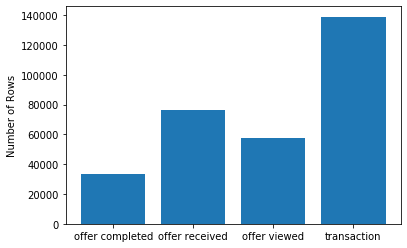

In [30]:
#Inspect the 'event' column
df = transcript.event.value_counts().sort_index()
plt.bar(df.index, df.values)
plt.ylabel("Number of Rows")
plt.show()

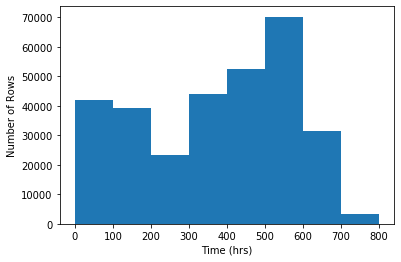

In [31]:
#Inspect the 'time' column
df = transcript['time']
plt.hist(df.values, bins=range(0,900,100))
plt.xlabel("Time (hrs)")
plt.ylabel("Number of Rows")
plt.show()

## 1.F) Clean the Transcript dataset

In [32]:
#Display data type of each column
transcript.dtypes

person    object
event     object
value     object
time       int64
dtype: object

In [33]:
#Count the number of nulls in each column
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [34]:
#Inspect how many different keys are contained in the 'value' column
transcript['value'].apply(lambda x: ",".join(list(x.keys()))).value_counts()

amount             138953
offer id           134002
offer_id,reward     33579
Name: value, dtype: int64

In [35]:
#In 'value' column replace 'offer id' with 'offer_id' to standardize the data
def clean_offer_id(dic):
    """
    Iterates over each key-value pair and replaces all occurences of 'offer id' with 'offer_id'
    in value attribute.
    """
    r = {}
    for k, v in dic.items():
        k = k.replace('offer id', 'offer_id')
        r.update({k:v})
    return r

trans_clean=transcript.copy()
trans_clean['value']=trans_clean['value'].apply(lambda x: clean_offer_id(x))

In [36]:
#Transpose 'value' column of key-value pairs into individual columns replacing the 'value' column
val = trans_clean['value'].tolist()
idx = trans_clean.index
trans_clean = trans_clean[['person', 'time', 'event']].join(pd.DataFrame(val, index=idx)).copy()
trans_clean.rename({'person':'person_id'}, axis=1, inplace=True)
trans_clean = trans_clean[['person_id', 'offer_id', 'event', 'time', 'amount', 'reward']]
trans_clean.sort_values(by=['person_id', 'offer_id', 'time'], axis=0, inplace=True)

In [37]:
#Total rows in dataset
trans_clean.shape

(306534, 6)

In [38]:
#Rows without an offer_id
trans_clean[trans_clean.offer_id.isnull()].head()

,person_id,offer_id,event,time,amount,reward
89291,0009655768c64bdeb2e877511632db8f,NaN,transaction,228,22.16,NaN
168412,0009655768c64bdeb2e877511632db8f,NaN,transaction,414,8.57,NaN
228422,0009655768c64bdeb2e877511632db8f,NaN,transaction,528,14.11,NaN
237784,0009655768c64bdeb2e877511632db8f,NaN,transaction,552,13.56,NaN
258883,0009655768c64bdeb2e877511632db8f,NaN,transaction,576,10.27,NaN


In [39]:
#Rows with an offer_id
trans_clean[~trans_clean.offer_id.isnull()].head()

,person_id,offer_id,event,time,amount,reward
247879,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,offer received,576,NaN,NaN
258884,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,offer completed,576,NaN,2.0
113605,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer received,336,NaN,NaN
139992,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer viewed,372,NaN,NaN
55972,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer received,168,NaN,NaN


In [40]:
#Keep only rows where person_id is in profile dataset
trans_clean = trans_clean[trans_clean['person_id'].isin(prof_clean.index)]
trans_clean.shape

(272762, 6)

In [41]:
#Remove duplicates
trans_clean.drop_duplicates(inplace=True)
trans_clean.shape

(272388, 6)

In [42]:
#Count null values in each column
trans_clean.isnull().sum()

person_id         0
offer_id     123957
event             0
time              0
amount       148431
reward       240318
dtype: int64

# 2) Develop Machine Learning Model

## 2.A) Create the Offers Dataset

The 'transcript' dataset contains information about transactions and offer status.  First these need to be separated.

In [43]:
#Create 'transactions' dataset
transactions = trans_clean[trans_clean['event']=="transaction"].reset_index(drop=True)
transactions.drop(['event', 'offer_id', 'reward'], axis=1, inplace=True)

#Create 'offers' dataset
offers = trans_clean[trans_clean['event']!="transaction"].reset_index(drop=True)
offers.drop('amount', axis=1, inplace=True)
offers.head()

,person_id,offer_id,event,time,reward
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,offer received,576,NaN
1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,offer completed,576,2.0
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer received,336,NaN
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer viewed,372,NaN
4,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer received,168,NaN


The 'offers' dataset contains timestamps for 'received', 'viewed', and 'completed' status.  The dataset needs to be re-factored to a single row per unique offer instance (person + offer + received time) with the correct time values for 'viewed' and 'completed' status.

In [44]:
#Create separate datasets for each event
offers_rcvd = offers[offers['event']=="offer received"][['person_id', 'offer_id', 'time']]
offers_rcvd.rename({'time':'time_r'}, inplace=True, axis=1)
offers_view = offers[offers['event']=="offer viewed"][['person_id', 'offer_id', 'time']]
offers_view.rename({'time':'time_v'}, inplace=True, axis=1)
offers_comp = offers[offers['event']=="offer completed"][['person_id', 'offer_id', 'time', 'reward']]
offers_comp.rename({'time':'time_c'}, inplace=True, axis=1)

Get 'view' time for each offer received.  Assume 'view' time is associated with the 'receive' time that has the smallest time difference.

In [45]:
#Merge 'received' and 'viewed' datasets on person/offer combination
df = offers_rcvd.merge(offers_view, how='left', on=['person_id', 'offer_id'], suffixes=['_r', '_v'])

#Keep rows where view time occurs after offer time
df['diff'] = df['time_v']-df['time_r']
df = df[(df['diff']>=0)]

#Remove duplicate 'view' times keeping the row with the least time difference
df.sort_values(['person_id', 'offer_id', 'time_v', 'diff'], inplace=True)
df.drop_duplicates(subset=['person_id', 'offer_id', 'time_v'], keep='first', inplace=True)
df = df[['person_id', 'offer_id', 'time_r', 'time_v']]

#Verify only 1 row per person+offer+time_r combination
df[df.duplicated(subset=['person_id', 'offer_id', 'time_r'], keep=False)].shape

(0, 4)

In [46]:
offers_new = offers_rcvd.merge(df, how='left', on = ['person_id', 'offer_id', 'time_r'])
offers_new.head()

,person_id,offer_id,time_r,time_v
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,456.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,540.0


Get 'completed' time for each offer received.  Assume 'completed' time is associated with the 'receive' time that has the smallest time difference.

In [47]:
#Merge 'received' and 'viewed' datasets on person/offer combination
df = offers_rcvd.merge(offers_comp, how='left', on=['person_id', 'offer_id'], suffixes=['_r', '_c'])

#Keep rows where view time occurs after offer time
df['diff'] = df['time_c']-df['time_r']
df = df[(df['diff']>=0)]

#Remove duplicate 'completed' times keeping the row with the least time difference
df.sort_values(['person_id', 'offer_id', 'time_c', 'diff'], inplace=True)
df.drop_duplicates(subset=['person_id', 'offer_id', 'time_c'], keep='first', inplace=True)

#Assume offers are completed in the order they are received
df.sort_values(['person_id', 'offer_id', 'time_r', 'time_c'], inplace=True)
df.drop_duplicates(subset=['person_id', 'offer_id', 'time_r'], keep='first', inplace=True)
df = df[['person_id', 'offer_id', 'time_r', 'time_c', 'reward']]

#Verify only 1 row per person+offer+time_r combination
df[df.duplicated(subset=['person_id', 'offer_id', 'time_r'], keep=False)].shape

(0, 5)

In [48]:
offers_new = offers_new.merge(df, how='left', on = ['person_id', 'offer_id', 'time_r'])
offers_new.head()

,person_id,offer_id,time_r,time_v,time_c,reward
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN,576.0,2.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,456.0,414.0,5.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,540.0,528.0,2.0


Add column indicating whether an offer was viewed or not (1=Yes, 0=No).

In [49]:
offers_new['viewed']=(~offers_new.time_v.isnull()).astype(int)
offers_new.head()

,person_id,offer_id,time_r,time_v,time_c,reward,viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN,576.0,2.0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0,NaN,NaN,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0,NaN,NaN,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,456.0,414.0,5.0,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,540.0,528.0,2.0,1


Add column indicating whether an offer was completed or not (1=Yes, 0=No).

In [50]:
offers_new['completed']=(~offers_new.time_c.isnull()).astype(int)
offers_new.head()

,person_id,offer_id,time_r,time_v,time_c,reward,viewed,completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN,576.0,2.0,0,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0,NaN,NaN,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0,NaN,NaN,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,456.0,414.0,5.0,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,540.0,528.0,2.0,1,1


Add a column indicating whether or not a reward was paid on an invalid offer completion.  An invalid completion occurs when the offer is completed prior to being viewed (1=Yes, 2=No).

In [51]:
#Offer Completed but Completed time prior to Viewed time or Offer not Viewed
offers_new['invalid_reward']=( 
    (offers_new.completed==1) & ((offers_new.time_c<offers_new.time_v) | (offers_new.viewed==0)) ).astype(int)
offers_new.head()

,person_id,offer_id,time_r,time_v,time_c,reward,viewed,completed,invalid_reward
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN,576.0,2.0,0,1,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0,NaN,NaN,1,0,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0,NaN,NaN,1,0,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,456.0,414.0,5.0,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,540.0,528.0,2.0,1,1,1


Summarize the Offers Dataset

In [52]:
#Calculate Overall Totals
offers_received = offers_new.shape[0]
offers_viewed = offers_new.viewed.sum()
offers_completed = offers_new.completed.sum()
total_rewards = offers_new[offers_new.completed==1].reward.sum()

#Calculate Valid/Invalid Totals
invalid_offers = offers_new.invalid_reward.sum()
valid_offers = offers_completed - invalid_offers
invalid_rewards = offers_new[offers_new.invalid_reward==1].reward.sum()
valid_rewards = total_rewards - invalid_rewards

#Total number of offers created
print("Total Offers Received: ", offers_received)
#Total number of offers viewed
print("Total Offers Viewed: ", offers_viewed)
#Total number of offers completed and reward dollars paid
print("Total Offers Completed: ", offers_completed)
print("Total Rewards Received: ${:,.0f}".format(total_rewards))

#Offers completed with a valid reward and reward dollars paid
print()
print("Offers Completed After Viewing: ", valid_offers)
print("Total Valid Rewards Received: ${:,.0f}".format(valid_rewards))

#Rewards paid on invalid offers
print()
print("Total Rewards Received Before Offer Viewed: ${:,.0f}".format(invalid_rewards))
print("% of Total Rewards Received {:.0%}".format(invalid_rewards/total_rewards))

Total Offers Received:  66501
Total Offers Viewed:  49860
Total Offers Completed:  32000
Total Rewards Received: $158,401

Offers Completed After Viewing:  22334
Total Valid Rewards Received: $110,912

Total Rewards Received Before Offer Viewed: $47,489
% of Total Rewards Received 30%


## 2.B) Create Machine Learning Classifier Model

First, prepare the data by combining datasets and scaling all continuous variables.

In [53]:
#Join Offers dataset to Portfolio and Profile datasets
df = offers_new[['person_id', 'offer_id', 'invalid_reward']].copy()
df = df.merge(prof_clean, on='person_id')
df = df.merge(port_clean, on='offer_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 66500
Data columns (total 29 columns):
person_id         66501 non-null object
offer_id          66501 non-null object
invalid_reward    66501 non-null int32
F                 66501 non-null int32
M                 66501 non-null int32
O                 66501 non-null int32
0-25              66501 non-null int32
26-50             66501 non-null int32
51-75             66501 non-null int32
75+               66501 non-null int32
2013              66501 non-null int32
2014              66501 non-null int32
2015              66501 non-null int32
2016              66501 non-null int32
2017              66501 non-null int32
2018              66501 non-null int32
0-40K             66501 non-null int32
40-80K            66501 non-null int32
80K+              66501 non-null int32
reward            66501 non-null int64
difficulty        66501 non-null int64
duration          66501 non-null int64
email             66501 non-nul

In [54]:
#Scale columns with continuous data to a scale of 0-1 to align with categorical values of 0 and 1.
df.reward = df.reward/df.reward.max()
df.difficulty = df.difficulty/df.difficulty.max()
df.duration = df.duration/df.duration.max()
df[['person_id', 'offer_id', 'reward', 'difficulty', 'duration']].head()

,person_id,offer_id,reward,difficulty,duration
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.2,0.5,0.7
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,0.2,0.5,0.7
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,0.2,0.5,0.7
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,0.2,0.5,0.7
4,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,0.2,0.5,0.7


Next, create the Training and Test datasets used to fit and evaluate the model.

In [55]:
#Split dataset into Features (X) and Result (y) datasets
X = df.drop(['person_id', 'offer_id', 'invalid_reward'], axis=1).copy()
y = df['invalid_reward']

In [56]:
#Split X,y datasets into Training and Test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

I am using the Gradient Boosting Classifier because I have had good luck with this classifier on other projects.  In a real production environment I would evaluate multiple Classifiers to determine which performs best for this scenario.

In [57]:
#Create estimator object using the Gradient Boosting Classifier class with default settings
cls = GradientBoostingClassifier(random_state=1)

#Train estimator on Training datasets
cls.fit(X_train, y_train)

#Assess accuracy of model using the Test datasets
y_pred = cls.predict(X_test)
accuracy_score(y_test, y_pred)

0.8545049921809215

The model predicts correctly 85% of the time with default settings.  Next I will use GridSearch to apply cross validation and attempt to tune the parameters to the optimal settings.

In [58]:
#Get current (default) parameter values of estimator
cls.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 1,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [59]:
#Using GridSearch, test the model using multiple values for specified parameters to determine 
#  which combination performs best.
parameters = {
    'learning_rate': [0, 0.1, 0.5, 1], 
    'max_depth': [2, 3, 4], 
    'max_features': [None, 0.25, 0.50, 0.75]
}
cls_cv = GridSearchCV(estimator=cls, param_grid = parameters, n_jobs = -1, cv=3, verbose = 3)
cls_cv.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  2.2min finished


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=1),
             n_jobs=-1,
             param_grid={'learning_rate': [0, 0.1, 0.5, 1],
                         'max_depth': [2, 3, 4],
                         'max_features': [None, 0.25, 0.5, 0.75]},
             verbose=3)

In [60]:
cls_cv.best_params_

{'learning_rate': 0.5, 'max_depth': 2, 'max_features': 0.25}

Based on this, we see that the optimal value for 'max_features' was at the end of the range provided which may indicate that the true optimal value is beyond this range.  I will try again expanding the allowable range.

In [61]:
parameters = {
    'learning_rate': [0.5], 
    'max_depth': [2], 
    'max_features': [0.1, 0.2, 0.3]
}
cls_cv = GridSearchCV(estimator=cls, param_grid = parameters, n_jobs = -1, cv=3, verbose = 3)
cls_cv.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    3.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    4.2s finished


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.5], 'max_depth': [2],
                         'max_features': [0.1, 0.2, 0.3]},
             verbose=3)

In [62]:
cls_cv.best_params_

{'learning_rate': 0.5, 'max_depth': 2, 'max_features': 0.3}

Re-fit the model using the optimal parameters determined above and retest the accuracy of the model.

In [63]:
#Refit the model
cls = GradientBoostingClassifier(random_state=1, learning_rate=0.5, max_depth=2, max_features=0.3)
cls.fit(X_train, y_train)


#Assess accuracy of model using the Test datasets
y_pred = cls.predict(X_test)
accuracy_score(y_test, y_pred)

0.8573920365692289

After tuning these parameters the model accuracy improved slightly from 85% to 86%.